In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load the datasets 
trader_df = pd.read_csv("historical_data.csv")
sentiment_df = pd.read_csv("fear_greed_index.csv")

In [9]:
# Display the first few rows
print(trader_df.head(10))

                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
5  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9900   
6  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9934   
7  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           8.0000   
8  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           8.0000   
9  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           8.0000   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      

In [7]:
print(sentiment_df.head(10))

    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05
5  1517895000      8   Extreme Fear  2018-02-06
6  1517981400     36           Fear  2018-02-07
7  1518067800     30           Fear  2018-02-08
8  1518154200     44           Fear  2018-02-09
9  1518240600     54        Neutral  2018-02-10


In [11]:
# Convert sentiment date to datetime
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# Convert trader timestamp to datetime
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format="%d-%m-%Y %H:%M")

# Merge sentiment with trader data by date
trader_df['date'] = trader_df['Timestamp IST'].dt.date
trader_df['date'] = pd.to_datetime(trader_df['date'])

# Merge on date
merged_df = pd.merge(trader_df, sentiment_df[['date', 'classification']], on='date', how='left')

merged_df[['Timestamp IST', 'Account', 'Execution Price', 'Size USD', 'Closed PnL', 'classification']].head()


,Timestamp IST,Account,Execution Price,Size USD,Closed PnL,classification
0,2024-12-02 22:50:00,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,7.9769,7872.16,0.0,Extreme Greed
1,2024-12-02 22:50:00,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,7.9800,127.68,0.0,Extreme Greed
2,2024-12-02 22:50:00,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,7.9855,1150.63,0.0,Extreme Greed
3,2024-12-02 22:50:00,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,7.9874,1142.04,0.0,Extreme Greed
4,2024-12-02 22:50:00,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,7.9894,69.75,0.0,Extreme Greed


In [12]:
# Group by sentiment classification and calculate mean PnL and trade counts
performance_by_sentiment = merged_df.groupby('classification').agg(
    avg_pnl=('Closed PnL', 'mean'),
    total_pnl=('Closed PnL', 'sum'),
    trade_count=('Closed PnL', 'count'),
    avg_trade_size=('Size USD', 'mean')
).reset_index()

performance_by_sentiment


,classification,avg_pnl,total_pnl,trade_count,avg_trade_size
0,Extreme Fear,34.537862,7.391102e+05,21400,5349.731843
1,Extreme Greed,67.892861,2.715171e+06,39992,3112.251565
2,Fear,54.290400,3.357155e+06,61837,7816.109931
3,Greed,42.743559,2.150129e+06,50303,5736.884375
4,Neutral,34.307718,1.292921e+06,37686,4782.732661


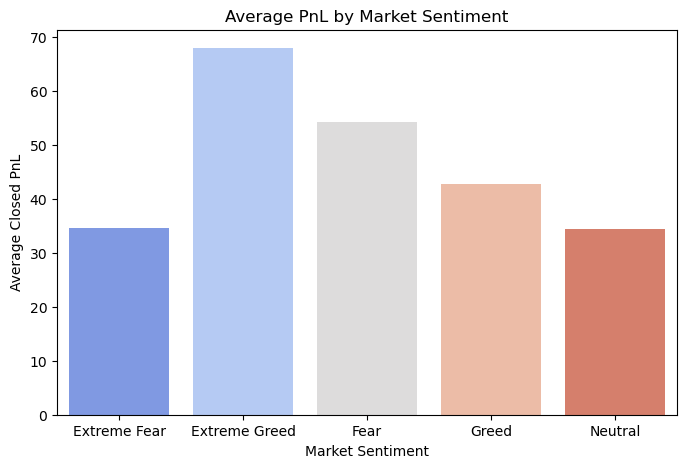

In [13]:
# Bar plot of average PnL by sentiment
plt.figure(figsize=(8, 5))
sns.barplot(data=performance_by_sentiment, x='classification', y='avg_pnl', palette='coolwarm')
plt.title('Average PnL by Market Sentiment')
plt.ylabel('Average Closed PnL')
plt.xlabel('Market Sentiment')
plt.show()


In [14]:
# Win rate per sentiment
merged_df['win'] = merged_df['Closed PnL'] > 0
win_rate = merged_df.groupby('classification')['win'].mean().reset_index().rename(columns={'win': 'win_rate'})

# Merge for combined view
performance_summary = pd.merge(performance_by_sentiment, win_rate, on='classification')
performance_summary


,classification,avg_pnl,total_pnl,trade_count,avg_trade_size,win_rate
0,Extreme Fear,34.537862,7.391102e+05,21400,5349.731843,0.370607
1,Extreme Greed,67.892861,2.715171e+06,39992,3112.251565,0.464943
2,Fear,54.290400,3.357155e+06,61837,7816.109931,0.420768
3,Greed,42.743559,2.150129e+06,50303,5736.884375,0.384828
4,Neutral,34.307718,1.292921e+06,37686,4782.732661,0.396991



1. **Highest Profitability in Extreme Greed**:

   * Traders had the highest **average PnL** and **win rate** during *Extreme Greed*, suggesting market confidence may correlate with better outcomes.

2. **Fear Isn't Always Bad**:

   * *Fear* periods also show relatively **high average PnL**, even though trade sizes were larger. This suggests skilled traders might be exploiting fear-driven volatility.

3. **Lower PnL and Win Rate in Extreme Fear**:

   * As expected, *Extreme Fear* results in **lowest win rate and profits**, which aligns with cautious or panic-driven trading.

4. **Trade Sizes vs. Sentiment**:

   * Traders placed **larger trades during Fear**, possibly betting on rebounds or overreactions.

---

 Strategy Implications

* **Momentum Traders** might benefit by focusing on *Extreme Greed* days.
* **Contrarian or Volatility Traders** could exploit *Fear* conditions using stricter risk management.
* Avoid scaling during *Extreme Fear* unless strong setups exist.
